In [1]:
import os
from glob import glob
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import cv2

C:\Development\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Global variables

In [2]:
DIR_TFRECORDS = 'data_small_tfrecords'
DATA_TRAIN = glob('./'+DIR_TFRECORDS+'/*.tfrecords')

NUM_OBJECTS = 20
MAX_DETECTIONS_PER_IMAGE = 20

GRID_SIZE = 32
GRID_H, GRID_W = 19, 19

ANCHORS_NORMALIZED = np.array(
    [
        [0.09112895, 0.06958421],
        [0.21102316, 0.16803947],
        [0.42625895, 0.26609842],
        [0.25476474, 0.49848   ],
        [0.52668947, 0.59138947]
    ]
)
ANCHORS = ANCHORS_NORMALIZED * np.array([GRID_H, GRID_W])
NUM_ANCHORS = ANCHORS.shape[0]

IMG_H, IMG_W = 608, 608  # GRID_H * GRID_SIZE = 19 * 32 = 608

COOEFFICIENT_OBJ = 1
COOEFFICIENT_NO_OBJ = 1
COOEFFICIENT_REG = 5

THRESHOLD_IOU_SCORES = 0.5
COEFF_LOSS_CONFIDENCE_OBJECT_PRESENT = 5
COEFF_LOSS_CONFIDENCE_OBJECT_ABSENT = 1
THRESHOLD_OUT_PROB = 0.5
THRESHOLD_IOU_NMS = 0.5

NUM_EPOCHS = 10
BATCH_SIZE = 1
MODEL_DIR = 'model'

DEBUG = False

## Utility

In [3]:
def sigmoid(x):
    return np.exp(x)/(1+np.exp(x))

def draw_adjusted_anchor(img, idx_h, idx_w, idx_a, label_bbox):
    # box_adjustment.shape = [5,]
    
    center_y = (label_bbox[0]+idx_h)*GRID_SIZE
    center_x = (label_bbox[1]+idx_w)*GRID_SIZE
    
    height = label_bbox[2] * ANCHORS[idx_a,0] * GRID_SIZE
    width = label_bbox[3] * ANCHORS[idx_a,1] * GRID_SIZE
     
    left = int(center_x - width/2)
    top = int(center_y - height/2)
    right = int(left + width)
    bottom = int(top + height)

    img = cv2.rectangle(img, (left, top), (right, bottom), color=(0, 255, 0), thickness=3)
    
    return img
    
def label(img, label):
    # unnormalize image
    img = (img * 255).astype(np.uint8)
    
    for idx_h in range(GRID_H):
        for idx_w in range(GRID_W):
            for idx_a in range(NUM_ANCHORS):
                if sigmoid(label[idx_h, idx_w, idx_a, 5]) > 0.1:
                    bbox = label[idx_h, idx_w, idx_a, :4]
                    img = draw_adjusted_anchor(img, idx_h, idx_w, idx_a, bbox)
    
    return img

def draw_output(img, output):
    # unnormalize image
    img = (img * 255).astype(np.uint8)
    
    output = output.astype(np.int32)
    for idx_box in range(output.shape[0]):
        bbox = output[idx_box]
        img = cv2.rectangle(img, (bbox[1], bbox[0]), (bbox[3], bbox[2]), color=(255, 0, 0), thickness=3)
    
    return img

## YOLO Network

In [4]:
def conv( x, 
          num_filters, 
          kernel_size, 
          strides = (1,1), 
          padding = 'same', 
          is_training = False, 
          activation = tf.nn.leaky_relu,
          name = None) :
    
    assert name != None, 'ERROR: conv: parameter \'name\' must be provided!\n'
    
    with tf.name_scope( name ) :
        
        # Convolutional Layer
        net = tf.layers.conv2d( inputs = x, 
                                filters = num_filters, 
                                kernel_size = kernel_size, 
                                strides = strides, 
                                padding = padding,
                                kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d(), 
                                bias_initializer = tf.zeros_initializer() )
        
        # Batch Normalization
        net = tf.layers.batch_normalization( inputs = net, 
                                             training = is_training )
        
        # Activation
        net = activation( net, alpha=0.01 )
        
        return net

def maxpool( x, pool_size, strides, padding='same', name=None ) :
    
    assert name != None, 'ERROR: maxpool: parameter \'name\' must be provided!\n'
    
    with tf.name_scope( name ) :
        
        # Max Pooling Layer
        net = tf.layers.max_pooling2d( inputs = x, 
                                       pool_size = pool_size, 
                                       strides = strides, 
                                       padding = padding, 
                                       name = name )
        
        return net

def layer_concat( layer1_out, layer2_out, block_size ) :
    layer2_out = tf.space_to_depth( layer2_out, block_size=block_size )
    return tf.concat( [layer1_out, layer2_out], axis=3 )

def YOLO_net( x, is_training ) : 
    
    net = conv( x, 32, (3,3), is_training=is_training, name='conv1' )
    net = maxpool( net, (2,2), (2,2), name='maxpool1' )
    net = conv( net, 64, (3,3), is_training=is_training, name='conv2' )
    net = maxpool( net, (2,2), (2,2), name='maxpool2' )
    
    net = conv( net, 128, (3,3), is_training=is_training, name='conv3' )
    net = conv( net, 64, (1,1), is_training=is_training, name='conv4' )
    net = conv( net, 128, (3,3), is_training=is_training, name='conv5' )
    net = maxpool( net, (2,2), (2,2), name='maxpool5' )
    
    net = conv( net, 256, (3,3), is_training=is_training, name='conv6' )
    net = conv( net, 128, (1,1), is_training=is_training, name='conv7' )
    net = conv( net, 256, (3,3), is_training=is_training, name='conv8' )
    net = maxpool( net, (2,2), (2,2), name='maxpool8' )
    
    net = conv( net, 512, (3,3), is_training=is_training, name='conv9' )
    net = conv( net, 256, (1,1), is_training=is_training, name='conv10' )
    net = conv( net, 512, (3,3), is_training=is_training, name='conv11' )
    net = conv( net, 256, (1,1), is_training=is_training, name='conv12' )
    skip_tail = conv( net, 512, (3,3), is_training=is_training, name='conv13' )
    net = maxpool( skip_tail, (2,2), (2,2), name='maxpool13' )
    
    net = conv( net, 1024, (3,3), is_training=is_training, name='conv14' )
    net = conv( net, 512, (1,1), is_training=is_training, name='conv15' )
    net = conv( net, 1024, (3,3), is_training=is_training, name='conv16' )
    net = conv( net, 512, (1,1), is_training=is_training, name='conv17' )
    net = conv( net, 1024, (3,3), is_training=is_training, name='conv18' )
    
    net = conv( net, 1024, (3,3), is_training=is_training, name='conv19' )
    net = conv( net, 1024, (3,3), is_training=is_training, name='conv20' )
    skip_head = conv( skip_tail, 64, (3,3), is_training=is_training, name='conv21' )
    net = layer_concat( net, skip_head, block_size=2 )
    net = conv( net, 1024, (3,3), is_training=is_training, name='conv22' )
    net = conv( net, NUM_ANCHORS * (NUM_OBJECTS + 5), (1,1), is_training=is_training, name='conv23' )
    
    out = tf.reshape( net, shape=(-1, GRID_H, GRID_W, NUM_ANCHORS, NUM_OBJECTS+5) )

    return out

def YOLO_net_test( x, is_training ) :
    net = tf.layers.flatten( x )
    net = tf.layers.dense( net, 128 )
    net = tf.layers.dense( net, 128 )
    net = tf.layers.dense( net, GRID_H*GRID_W*NUM_ANCHORS*(NUM_OBJECTS+5) )
    
    out = tf.reshape( net, shape=(-1, GRID_H, GRID_W, NUM_ANCHORS, NUM_OBJECTS+5) )

    return out

## Yolo Loss function

In [5]:
def apply_transformations(predictions):
    predictions_yx = tf.sigmoid(predictions[..., 0:2])
    predictions_hw = tf.exp(predictions[...,2:4])
    predictions_prob_obj = tf.sigmoid(predictions[...,4:5])
    predictions_prob_class = tf.nn.softmax(predictions[...,5:])
    
    return predictions_yx, predictions_hw, predictions_prob_obj, predictions_prob_class

def get_coordinates(h, w):
    coordinates_y = tf.range(h)
    coordinates_x = tf.range(w)
    x, y = tf.meshgrid(coordinates_x, coordinates_y)
    coordinates = tf.stack([y,x], axis=-1)
    coordinates = tf.reshape(coordinates, [1, h, w, 1, 2])
    coordinates = tf.cast(coordinates, tf.float32)
    
    return coordinates

def grid2normalized(predictions_yx, predictions_hw):    
    # create cartesian coordinates on grid space
    coordinates = get_coordinates(GRID_H, GRID_W)
    
    # map from grid space to [0,19] space
    anchors = tf.cast(tf.reshape(ANCHORS, [1, 1, 1, ANCHORS.shape[0], 2]), dtype=tf.float32)  # [0,19] space
    predictions_yx += coordinates
    predictions_hw *= anchors
    
    # map from [0,19] space to [0,1] space
    shape = tf.cast(tf.reshape([GRID_H, GRID_W], [1, 1, 1, 1, 2]), tf.float32)
    predictions_yx /= shape
    predictions_hw /= shape
    
    return predictions_yx, predictions_hw

def get_boxes_gt(args_map):
    # extract ground truth bboxes wherever prob_obj = 1
    mask_object = tf.cast(tf.reshape(args_map[1], [GRID_H, GRID_W, NUM_ANCHORS]), tf.bool)
    bboxes = tf.boolean_mask(args_map[0], mask_object)
    # bboxes.shape = [NUM_DETECTIONS, 4]; NUM_DETECTIONS vary with each image
    
    # pad bboxes so that bboxes is fixed dimension (fix NUM_DETECTIONS to MAX_DETECTIONS_PER_IMAGE)
    pad = tf.zeros((MAX_DETECTIONS_PER_IMAGE - tf.shape(bboxes)[0], 4))  # TODO: when NUM_DETECTIONS > MAX_DETECTIONS_PER_IMAGE
    bboxes = tf.concat([bboxes, pad], axis=0)
    
    return bboxes

def get_iou_scores(predictions_yx, predictions_hw, bboxes_gt):
    # predictions_yx.shape = predictions_hw.shape = [BATCH_SIZE, GRID_H, GRID_W, NUM_ANCHORS, 2]
    # bboxes_gt.shape = [BATCH_SIZE, MAX_DETECTIONS_PER_IMAGE, 4]
    
    # compute ious for each anchor in each grid in axis=4
    predictions_yx = tf.expand_dims(predictions_yx, 4)
    predictions_hw = tf.expand_dims(predictions_hw, 4)
    
    predictions_min = predictions_yx - predictions_hw/2.
    predictions_max = predictions_yx + predictions_hw/2.
    
    bboxes_gt = tf.reshape(bboxes_gt, [tf.shape(bboxes_gt)[0], 1, 1, 1, MAX_DETECTIONS_PER_IMAGE, 4])
    bboxes_gt_yx = bboxes_gt[..., 0:2]
    bboxes_gt_hw = bboxes_gt[..., 2:4]
    
    bboxes_gt_min = bboxes_gt_yx - bboxes_gt_hw/2.
    bboxes_gt_max = bboxes_gt_yx + bboxes_gt_hw/2.
    
    intersection_min = tf.maximum(predictions_min, bboxes_gt_min)
    intersection_max = tf.minimum(predictions_max, bboxes_gt_max)
    intersection_hw = tf.maximum(intersection_max - intersection_min, 0.)
    area_intersection = intersection_hw[..., 0] * intersection_hw[..., 1]
    
    area_predictions = predictions_hw[...,0] * predictions_hw[...,1]
    area_bboxes_gt = bboxes_gt_hw[...,0] * bboxes_gt_hw[...,1]
    area_union = area_bboxes_gt + area_predictions - area_intersection
    iou = area_intersection / area_union
    
    return iou

def get_confidence_loss(labels_prob_obj, iou_mask, predictions_prob_obj):
    mask_object_absent = (1 - labels_prob_obj) * (1 - iou_mask)
    loss_object_absent = mask_object_absent * tf.square(predictions_prob_obj)
    
    loss_object_present = labels_prob_obj * tf.square(1-predictions_prob_obj)
    
    loss_confidence = COEFF_LOSS_CONFIDENCE_OBJECT_ABSENT * loss_object_absent \
            + COEFF_LOSS_CONFIDENCE_OBJECT_PRESENT * loss_object_present
    
    return tf.reduce_sum(loss_confidence)
    
def get_classification_loss(labels_prob_obj, labels_class, predictions_prob_class):
    labels_class = tf.cast(labels_class, tf.int32)
    labels_class = tf.one_hot(labels_class, NUM_OBJECTS)
    
    loss_classification = labels_prob_obj * tf.squared_difference(labels_class, predictions_prob_class)
    
    return tf.reduce_sum(loss_classification)

def get_regression_loss(labels_bbox, predictions_bbox, labels_prob_obj):
    loss_regression = labels_prob_obj * tf.squared_difference(labels_bbox,predictions_bbox)
    
    return tf.reduce_sum(loss_regression)

def get_loss(predictions, labels): 
    # predictions.shape = [BATCH_SIZE, GRID_H, GRID_W, NUM_ANCHORS, 5+NUM_OBJECTS] (they are in grid space)
    # labels.shape = [BATCH_SIZE, GRID_H, GRID_W, NUM_ANCHORS, 6]
    
    # apply corresponding transformations on predictions
    predictions_yx, predictions_hw, predictions_prob_obj, predictions_prob_class = apply_transformations(predictions)
    
    # map predictions_bbox to [0,1] space
    predictions_yx, predictions_hw = grid2normalized(predictions_yx, predictions_hw)
    
    # map labels_bbox to [0,1] space
    labels_yx, labels_hw = grid2normalized(labels[...,0:2], labels[...,2:4])
    
    # get ground truth bboxes using labels_bbox & prob_obj in labels
    labels_bbox = tf.concat([labels_yx, labels_hw], axis=-1)
    bboxes_gt = tf.map_fn(get_boxes_gt, (labels_bbox, labels[...,5]), dtype=tf.float32)
    
    # compute iou scores for each anchor in each grid for all bboxes_gt
    iou_scores = get_iou_scores(predictions_yx, predictions_hw, bboxes_gt)
     
    # keep anchors whose iou_scores are above THRESHOLD_IOU_SCORES
    iou_scores_best = tf.reduce_max(iou_scores, axis=4, keep_dims=True)
    iou_mask = tf.cast(iou_scores_best > THRESHOLD_IOU_SCORES, tf.float32)
    
    
    ## Loss
    # object confidence loss (presence and absence)
    loss_confidence = get_confidence_loss(labels[...,5:6], iou_mask, predictions_prob_obj)
    
    # classification loss
    loss_classification = get_classification_loss(labels[...,5:6], labels[...,4], predictions_prob_class)
    
    # regression loss
    predictions_bbox = tf.concat([predictions_yx, predictions_hw], axis=-1)
    loss_regression = get_regression_loss(labels_bbox, predictions_bbox, labels[...,5:6])
    
    # total loss
    loss = ( loss_confidence + loss_classification + loss_regression ) / tf.cast(tf.shape(labels)[0], tf.float32)
    
    return loss

## Post-processing

In [6]:
def center2corner(predictions_yx, predictions_hw):
    # predictions_yx = [GRID_H, GRID_W, NUM_ANCHORS, 2]
    
    bbox_min = predictions_yx - (predictions_hw/2.)
    bbox_max = predictions_yx + (predictions_hw/2.)
    
    predictions_corner = tf.concat([bbox_min[...,0:1], bbox_min[...,1:2], bbox_max[...,0:1], bbox_max[...,1:2]], axis=-1)
    return predictions_corner

def get_filtered_predictions(predictions_corner, predictions_prob_obj, predictions_prob_class):
    # compute overall prob for each anchor in each grid
    predictions_prob = predictions_prob_obj * predictions_prob_class
    
    # get max prob among all classes at each anchor in each grid
    predictions_idx_class_max = tf.argmax(predictions_prob, axis=-1)
    predictions_prob = tf.reduce_max(predictions_prob, axis=-1)
    
    # compute filter mask
    mask_filter = predictions_prob >= THRESHOLD_OUT_PROB
    
    # apply mask on output
    bbox_filtered = tf.boolean_mask(predictions_corner, mask_filter)
    prob_filtered = tf.boolean_mask(predictions_prob, mask_filter)
    idx_class_filtered = tf.boolean_mask(predictions_idx_class_max, mask_filter)
    
    return bbox_filtered, prob_filtered, idx_class_filtered


def predictions2outputs(predictions):
    # apply corresponding transformations on predictions
    predictions_yx, predictions_hw, predictions_prob_obj, predictions_prob_class = apply_transformations(predictions)
    
    # map predictions_bbox to [0,1] space
    predictions_yx, predictions_hw = grid2normalized(predictions_yx, predictions_hw)
    
    # represent boxes using corners
    predictions_corner = center2corner(predictions_yx, predictions_hw)
    
    # filter predictions based on (prob_obj * prob_class). (needs to be done separately for each image in batch)
    bbox_filtered, prob_filtered, idx_class_filtered = get_filtered_predictions(predictions_corner, predictions_prob_obj, predictions_prob_class)
    # bbox_filtered.shape = [BATCH_SIZE, NUM_FILTERED, 4]
    
    # TODO: perform nms for each class separately
    # scale boxes from [0,1] to image space
    img_space = tf.reshape(tf.cast(tf.stack([IMG_H, IMG_W, IMG_H, IMG_W]), tf.float32), [1, 1, 4])
    bbox_filtered = tf.reshape(bbox_filtered * img_space, [-1, 4])
    
    # perform non-max suppression
    bbox_nms_indices = tf.image.non_max_suppression(bbox_filtered, tf.reshape(prob_filtered,[-1]), MAX_DETECTIONS_PER_IMAGE)
    bbox_nms = tf.gather(bbox_filtered, bbox_nms_indices)
    prob_nms = tf.expand_dims(tf.gather(prob_filtered, bbox_nms_indices), axis=-1)
    idx_class_nms = tf.expand_dims(tf.cast(tf.gather(idx_class_filtered, bbox_nms_indices), tf.float32), axis=-1)
    
    # concat return data
    output = tf.concat([bbox_nms, prob_nms, idx_class_nms], axis=-1)
    
    return tf.expand_dims(output, axis=0)

## Estimator

In [7]:
def parse_record(record):
    # dictionary as per saved TFRecord
    keys_to_features = {
        'img': tf.FixedLenFeature(shape=(), dtype=tf.string),
        'label': tf.FixedLenFeature(shape=(), dtype=tf.string),
    }

    # parse record
    parsed = tf.parse_single_example(record, keys_to_features)

    # decode image
    img = tf.decode_raw(parsed['img'], tf.uint8)
    img = tf.cast(tf.reshape(img, [IMG_H, IMG_W, 3]), tf.float32)
    img /= 255.  # normalize

    # decode label
    label = tf.decode_raw(parsed['label'], tf.float32)
    label = tf.reshape(label, [GRID_H, GRID_W, NUM_ANCHORS, 6])

    return {'img': img}, label

def input_fn_train(data_file):    
    # dataset processing
    dataset = tf.data.TFRecordDataset(data_file)
    
    dataset = dataset.map(parse_record)
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.repeat()
    
    iterator = dataset.make_one_shot_iterator()
    img, label = iterator.get_next()
    
    return img, label

def input_fn_predict(data_file):    
    # dataset processing
    dataset = tf.data.TFRecordDataset(data_file)
    
    dataset = dataset.map(parse_record)
    dataset = dataset.batch(BATCH_SIZE)
    
    iterator = dataset.make_one_shot_iterator()
    img, label = iterator.get_next()
    
    return img, label

def get_feature_columns():
    img = tf.feature_column.numeric_column('img', dtype=tf.float32)
    
    return img

def model_fn(features, labels, mode, params):
    # input layer
    features = tf.feature_column.input_layer(features, params['feature_columns'])
    imgs = tf.reshape(features, [-1, IMG_H, IMG_W, 3])
    # imgs.shape = (BATCH_SIZE, 608, 608, 3)
    
    # YOLO Network
#     predictions = YOLO_net_test( imgs, mode == tf.estimator.ModeKeys.TRAIN )
    # predictions.shape = (BATCH_SIZE, 19, 19, 5, 25)
    
    # dense
    x = tf.image.resize_images(imgs, [64, 64])
    x = tf.layers.flatten(x)
    x = tf.layers.dense(x, 256, activation=tf.nn.relu, kernel_initializer=tf.glorot_uniform_initializer())
    x = tf.layers.dense(x, 256, activation=tf.nn.relu, kernel_initializer=tf.glorot_uniform_initializer())
    x = tf.layers.dense(x, 256, activation=tf.nn.relu, kernel_initializer=tf.glorot_uniform_initializer())
    x = tf.layers.dense(x, 256, activation=tf.nn.relu, kernel_initializer=tf.glorot_uniform_initializer())
    x = tf.layers.dense(x, GRID_H*GRID_W*NUM_ANCHORS*(5+NUM_OBJECTS))
    predictions = tf.reshape(x, [-1, GRID_H, GRID_W, NUM_ANCHORS, 5+NUM_OBJECTS])
    
#     # CNN
#     with tf.name_scope('CNN'):
#         x = tf.layers.conv2d(imgs, filters=8, kernel_size=5, activation=tf.nn.relu, padding='same')
#         x = tf.layers.max_pooling2d(x, pool_size=4, strides=4)
        
#         # x.shape = (BATCH_SIZE, 152, 152, 8)

#         x = tf.layers.conv2d(x, filters=64, kernel_size=3, activation=tf.nn.relu, padding='same')
#         x = tf.layers.max_pooling2d(x, pool_size=4, strides=4)
#         # x.shape = (BATCH_SIZE, 38, 38, 64)

#         x = tf.layers.conv2d(x, filters=125, kernel_size=3, activation=tf.nn.relu, padding='same')
#         x = tf.layers.max_pooling2d(x, pool_size=2, strides=2)
#         # x.shape = (BATCH_SIZE, 19, 19, 125)

#         predictions = tf.reshape(x, (-1, GRID_H, GRID_W, params['num_anchors'], 5+params['num_objects']))
#         # output.shape = (BATCH_SIZE, 19, 19, 5, 25)
    
    ## PREDICT
    if mode == tf.estimator.ModeKeys.PREDICT:
        outputs = predictions2outputs(predictions)
        outputs_dict = {
            'imgs': imgs,
            'outputs': outputs
        }
        return tf.estimator.EstimatorSpec(mode, predictions=outputs_dict)
    
    # compute loss
    with tf.name_scope('Loss'):
        loss = get_loss(predictions, labels)
    tf.summary.scalar('loss_summary', loss)
    
    ## EVALUATE
#     # compute evaluation metrics
#     mse = tf.metrics.mean_squared_error(labels=labels, predictions=predictions, name='mse_op')
#     metrics = {'mse': mse}
#     tf.summary.scalar('mse', mse[1])
#     if mode == tf.estimator.ModeKeys.EVAL:
#         return tf.estimator.EstimatorSpec(mode, loss=loss, eval_metric_ops=metrics)
    
    ## TRAIN
    assert mode == tf.estimator.ModeKeys.TRAIN
    with tf.name_scope('optimizer'):
        optimizer = tf.train.AdamOptimizer(0.0001)
        train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)

## Model

In [8]:
# get feature columns
feature_columns = get_feature_columns()

# training configuration
run_config = tf.estimator.RunConfig().replace(keep_checkpoint_max=1, save_summary_steps=10)

# define model
model = tf.estimator.Estimator(
    model_fn=model_fn,
    params={
        'feature_columns': feature_columns,
        'num_anchors': ANCHORS.shape[0],
        'num_objects': NUM_OBJECTS
    },
    model_dir=MODEL_DIR,
    config=run_config
)

INFO:tensorflow:Using config: {'_model_dir': 'model', '_tf_random_seed': None, '_save_summary_steps': 10, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 1, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000281388EB9E8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


## Train

In [9]:
model.train(input_fn=lambda: input_fn_train(DATA_TRAIN), steps=100000)

INFO:tensorflow:Calling model_fn.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from model\model.ckpt-1
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2 into model\model.ckpt.
INFO:tensorflow:loss = 452.0799, step = 2
INFO:tensorflow:global_step/sec: 8.74431
INFO:tensorflow:loss = 6.047411, step = 102 (11.438 sec)
INFO:tensorflow:global_step/sec: 9.33968
INFO:tensorflow:loss = 30.308756, step = 202 (10.706 sec)
INFO:tensorflow:global_step/sec: 9.34143
INFO:tensorflow:loss = 10.309765, step = 302 (10.706 sec)
INFO:tensorflow:global_step/sec: 9.32487
INFO:tensorflow:loss = 15.580149, step = 402 (10.724 sec)
INFO:tensorflow:global_step/sec: 9.34492
INFO:tensorflow:loss = 10.059487, step = 502 (10.701 sec)
INFO:tensorflow:global_step/s

## Predict

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from model\model.ckpt-100001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


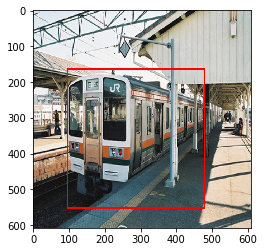

In [13]:
# TODO: map_fn for get_get_filtered_predictions needs return elements to be padded
BATCH_SIZE = 1
predictions = model.predict(input_fn=lambda: input_fn_predict(DATA_TRAIN))

idx = 40
iteration = 0
for p in predictions:
    i, o = p['imgs'], p['outputs']
    if iteration == idx:
        break
    iteration += 1

img = draw_output(i, o)
plt.imshow(img)
plt.show()